In [14]:
# This will install the mibian library, which provides options pricing and Greek calculations based on the Black-Scholes-Merton model.
!pip install mibian



In [15]:
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For data visualization
from bs4 import BeautifulSoup  # For web scraping and HTML parsing
import pandas as pd  # For data manipulation and analysis
from urllib.request import urlopen, Request  # For making HTTP requests
from urllib.error import HTTPError  # For handling HTTP errors
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # For sentiment analysis
import mibian  # For options pricing and Greek calculations
import os  # For operating system related functionalities


In [16]:
import nltk  # Natural Language Toolkit library for text processing and analysis

nltk.download('vader_lexicon')  # Download the VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sainithingovind/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [32]:
# Define the base URL for the Finviz website
web_url = 'https://finviz.com/quote.ashx?t='


In [33]:
# Dictionary to store news tables
news_tables = {}

# List of tickers
tickers = ['NVDA', 'WMT', 'JPM']


In [36]:
for tick in tickers:
    # Construct the URL for the specific ticker
    url = web_url + tick

    # Create a request object with the URL and a User-Agent header
    req = Request(url=url, headers={"User-Agent": "Mozilla/5.0"})

    # Try to open the URL and retrieve the response
    try:
        response = urlopen(req)
        html = BeautifulSoup(response, "html.parser")

        # Find the news table in the HTML
        news_table = html.find(id='news-table')

        # Check if the news table is found
        if news_table is None:
            print(f"Could not find news table for {tick}")
        else:
            # Store the news table in the dictionary using the ticker as the key
            news_tables[tick] = news_table
            print(f"Found news table for {tick}")

    # Handle HTTP errors
    except HTTPError as e:
        print(f"Could not access {url}: {e}")


Found news table for NVDA
Found news table for WMT
Found news table for JPM


In [37]:
news_tables
#from abve line took payload and created an sample.html to understand payload

{'NVDA': <table border="0" cellpadding="1" cellspacing="0" class="fullview-news-outer news-table" id="news-table" width="100%">
 <tr class="cursor-pointer has-label" onclick="trackAndOpenNews(event, 'Motley Fool', 'https://finance.yahoo.com/m/9b62f4c9-dd00-34bd-b4d3-3b5320f7b6b9/2-leading-tech-stocks-to-buy.html');">
 <td align="right" width="130">
             Today 11:11AM
         </td>
 <td align="left">
 <div class="news-link-container">
 <div class="news-link-left">
 <a class="tab-link-news" href="https://finance.yahoo.com/m/9b62f4c9-dd00-34bd-b4d3-3b5320f7b6b9/2-leading-tech-stocks-to-buy.html" rel="nofollow" target="_blank">2 Leading Tech Stocks to Buy in 2025</a>
 </div>
 <div class="news-link-right">
 <span>(Motley Fool)</span></div></div></td></tr>
 <tr class="cursor-pointer has-label" onclick="trackAndOpenNews(event, 'Motley Fool', 'https://finance.yahoo.com/m/5ead8b0e-2c0f-3071-95c3-5f85f59154ce/broadcom-vs.-advanced-micro.html');">
 <td align="right" width="130">
        

In [38]:
news_list = []
for file_name, news_table in news_tables.items():
    for i in news_table.findAll('tr'):

        a_tag = i.a # fixed this part - when a is None code breaks
        if a_tag is not None:
            text = a_tag.get_text() # here collecting text from achor tag inside each table data row
            date_scrape = i.td.text.split() # list of date and time or may be list of time
            if len(date_scrape) == 1:  # if list has one element then that is time
                time = date_scrape[0]
            #if list has two elements then  date is first element at index 0 and time is at index 1
            else:
                # here once date is set it will insert for every instance even where there is no date
                date = date_scrape[0]
                time = date_scrape[1]
            tick = file_name
            news_list.append([tick, date, time, text]) # appending data to list
        else:
            # few table data has no anchor tags which means it has no data in it
            # sending them if else loop to skip thoses tags to avoid nan
            print("Skipping row without 'a' tag: ", i)


Skipping row without 'a' tag:  <tr>
<td align="right" width="130">07:00AM</td>
<td align="left" id="IC_D_3x8_1"><span class="block text-2xs text-gray-500 leading-none">Loading…</span></td>
</tr>
Skipping row without 'a' tag:  <tr>
<td align="right" width="130">10:37AM</td>
<td align="left" id="IC_D_3x8_2"><span class="block text-2xs text-gray-500 leading-none">Loading…</span></td>
</tr>
Skipping row without 'a' tag:  <tr>
<td align="right" width="130">03:53PM</td>
<td align="left" id="IC_D_3x8_3"><span class="block text-2xs text-gray-500 leading-none">Loading…</span></td>
</tr>
Skipping row without 'a' tag:  <tr>
<td align="right" width="130">02:33PM</td>
<td align="left" id="IC_D_3x8_1"><span class="block text-2xs text-gray-500 leading-none">Loading…</span></td>
</tr>
Skipping row without 'a' tag:  <tr>
<td align="right" width="130">10:40AM</td>
<td align="left" id="IC_D_3x8_2"><span class="block text-2xs text-gray-500 leading-none">Loading…</span></td>
</tr>
Skipping row without 'a' 

In [39]:
# Create a sentiment analyzer object
vader = SentimentIntensityAnalyzer()

# Define the columns for the news DataFrame
columns = ['ticker', 'date', 'time', 'headline']

# Create a DataFrame to store the news data with the specified columns
news_df = pd.DataFrame(news_list, columns=columns)

# Check for missing values in the DataFrame
news_df.isnull().sum()


ticker      0
date        0
time        0
headline    0
dtype: int64

In [40]:
# Calculate sentiment scores for each headline in the news DataFrame
scores = news_df['headline'].apply(vader.polarity_scores).tolist()

# Print the sentiment scores for the first three headlines
print(scores[0:3])


[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 0.852, 'pos': 0.148, 'compound': 0.3182}, {'neg': 0.137, 'neu': 0.863, 'pos': 0.0, 'compound': -0.2263}]


In [41]:
# Create a DataFrame from the list of sentiment scores
scores_df = pd.DataFrame(scores)

# Join the scores DataFrame with the news DataFrame
news_df = news_df.join(scores_df, rsuffix='_right')

# Display the updated news DataFrame with sentiment scores
news_df


,ticker,date,time,headline,neg,neu,pos,compound
0,NVDA,Today,11:11AM,2 Leading Tech Stocks to Buy in 2025,0.000,1.000,0.000,0.0000
1,NVDA,Today,10:15AM,Broadcom vs. Advanced Micro Devices: Wall Stre...,0.000,0.852,0.148,0.3182
2,NVDA,Today,10:13AM,"AI Stocks: Tech Giants, Cloud Titans Face 'Sho...",0.137,0.863,0.000,-0.2263
3,NVDA,Today,10:07AM,Veteran analyst sounds the alarm on Google and...,0.231,0.769,0.000,-0.3400
4,NVDA,Today,08:30AM,Why Trump reciprocal tariffs should terrify bu...,0.183,0.611,0.206,-0.1531
...,...,...,...,...,...,...,...,...
295,JPM,Jan-30-25,01:14PM,Blackstone in talks to buy stake in New York C...,0.000,1.000,0.000,0.0000
296,JPM,Jan-30-25,10:00AM,"60-Year-Old Retiree Earning $6,000 Per Month i...",0.000,1.000,0.000,0.0000
297,JPM,Jan-30-25,09:30AM,Brokers Suggest Investing in JPMorgan Chase & ...,0.000,1.000,0.000,0.0000
298,JPM,Jan-30-25,07:46AM,Q2 2025 Wolfspeed Inc Earnings Call,0.000,1.000,0.000,0.0000


In [42]:
from datetime import datetime

# Replace 'Today' with the current date
news_df['date'] = news_df['date'].replace({'Today': datetime.now().date()})

# Convert the 'date' column to datetime
news_df['date'] = pd.to_datetime(news_df['date']).dt.date

# Remove rows where date conversion failed
news_df = news_df.dropna(subset=['date'])

# Print the updated 'date' column
print(news_df['date'])


0      2025-02-16
1      2025-02-16
2      2025-02-16
3      2025-02-16
4      2025-02-16
          ...    
295    2025-01-30
296    2025-01-30
297    2025-01-30
298    2025-01-30
299    2025-01-30
Name: date, Length: 300, dtype: object


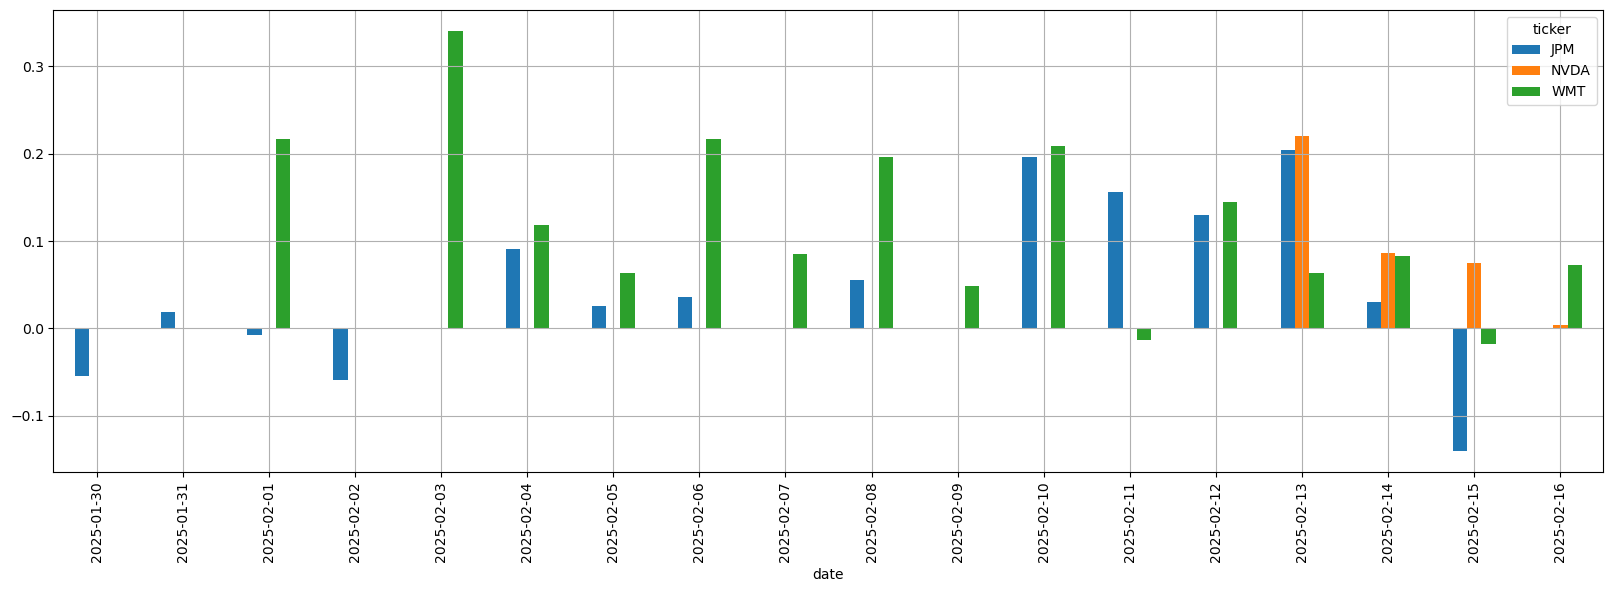

In [43]:
# Set the figure size for the plot
plt.rcParams['figure.figsize'] = [20, 6]

# Select the desired columns for calculating mean scores
columns = ['ticker', 'date', 'neg', 'neu', 'pos', 'compound']

# Calculate the mean scores by grouping the data by ticker and date
mean_scores = news_df[columns].groupby(['ticker', 'date']).mean().reset_index()

# Pivot the mean_scores DataFrame to have dates as rows and tickers as columns, with compound scores as values
mean_scores = mean_scores.pivot(index='date', columns='ticker', values='compound')

# Plot the mean scores as a bar plot
mean_scores.plot(kind='bar')

# Add grid lines to the plot
plt.grid()

# Display the plot
plt.show()



In [44]:
  # Install the yfinance library
#!pip install yfinance

import yfinance as yf  #I mport the yfinance library for accessing Yahoo Finance data


In [49]:
Infosys = yf.Ticker('INFY')  # Create a Ticker object for the stock symbol 'INFY'
stock_price = Infosys.get_info()['previousClose']  # Get the previous close stock price for Infosys

strike_price = 15.87  # Define the strike price for the option
risk_free_rate = yf.Ticker('^TNX').get_info()['previousClose']  # Get the previous close risk-free rate

implied_volatility = 25  # Define the implied volatility for the option
time_to_expiration = 180  # Define the time to expiration for the option in days

bs = mibian.BS([stock_price, strike_price, risk_free_rate, time_to_expiration], volatility=implied_volatility)
# Create a Black-Scholes object (bs) with the necessary parameters for options pricing


In [50]:
Infosys_portfolio = stock_price * 100  # Calculate the current value of Infosys holdings for 100 shares
print(f'The current value of Infosys holdings per 100 shares: ${Infosys_portfolio}')


The current value of Infosys holdings per 100 shares: $2174.0


In [52]:
premium_price = bs.putPrice  # Get the put option premium price from the Black-Scholes model
print(f'Purchasing a put with a strike price of {strike_price}, the portfolio is protected up to ${(strike_price - premium_price) * 100:.2f}')


Purchasing a put with a strike price of 15.87, the portfolio is protected up to $1583.62


In [53]:
stock_data = Infosys.history(period="5y")["Close"].values  # Get the historical closing prices for Infosys stock
# Generate an array of 100 equally spaced stock prices between the minimum and maximum values of stock_data
stock_price = np.linspace(min(stock_data), max(stock_data), 100)



In [54]:
# Calculate the protection provided by the put option for each stock price in stock_price
# If the protection value is greater than the maximum protection value (strike_price - premium_price) * 100,
# use the individual protection value, otherwise use the maximum protection value
protect_put = [(stock - premium_price) * 100 if (stock - premium_price) * 100 > (strike_price - premium_price) * 100 else (strike_price - premium_price) * 100 for stock in stock_price]


In [55]:
# Calculate the payoff of the put option for each stock price in stock_price
# The payoff is the maximum of (strike_price - stock) * 100 and 0
put_payoff = [max((strike_price - stock) * 100, 0) for stock in stock_price]


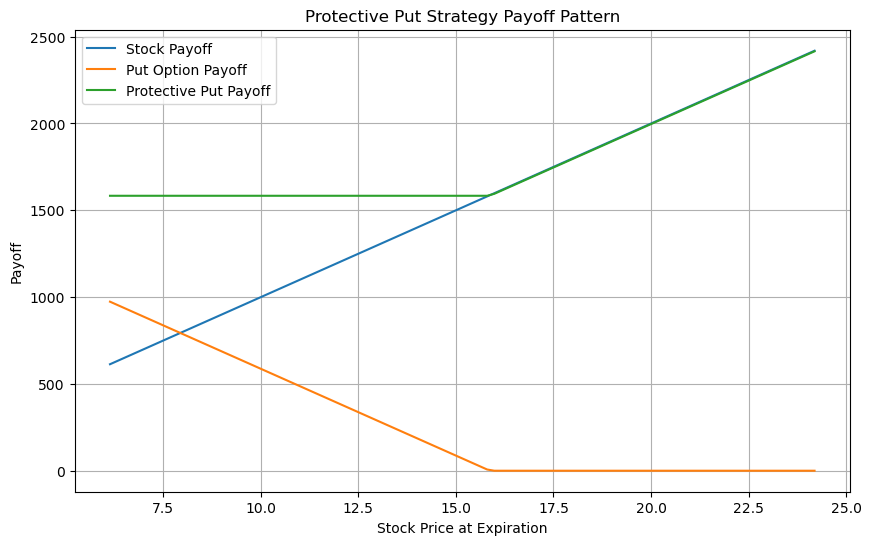

In [56]:
plt.figure(figsize=(10, 6))
# Plot the stock payoff, put option payoff, and protective put payoff
plt.plot(stock_price, stock_price * 100, label="Stock Payoff")
plt.plot(stock_price, put_payoff, label="Put Option Payoff")
plt.plot(stock_price, protect_put, label="Protective Put Payoff")

# Set the labels and title for the plot
plt.xlabel("Stock Price at Expiration")
plt.ylabel("Payoff")
plt.title("Protective Put Strategy Payoff Pattern")

# Display the legend
plt.legend()

# Enable grid lines
plt.grid(True)

# Show the plot
plt.show()


In [57]:
delta = bs.putDelta  # Calculate the put option delta using the Black-Scholes model
gamma = bs.gamma  # Calculate the option gamma
vega = bs.vega  # Calculate the option vega
theta = bs.putTheta  # Calculate the put option theta using the Black-Scholes model
rho = bs.putRho  # Calculate the put option rho using the Black-Scholes model

# Print the premium price, delta, gamma, vega, theta, and rho
print("premium_price: ", premium_price, "Delta: ", delta, "Gamma: ", gamma, "Vega: ", vega, "Theta: ", theta, "Rho: ", rho)


premium_price:  0.03375666732052085 Delta:  -0.022345432288154613 Gamma:  0.013933470862767989 Vega:  0.00811891589614516 Theta:  -0.0004994040887531027 Rho:  -0.0025621464588411057


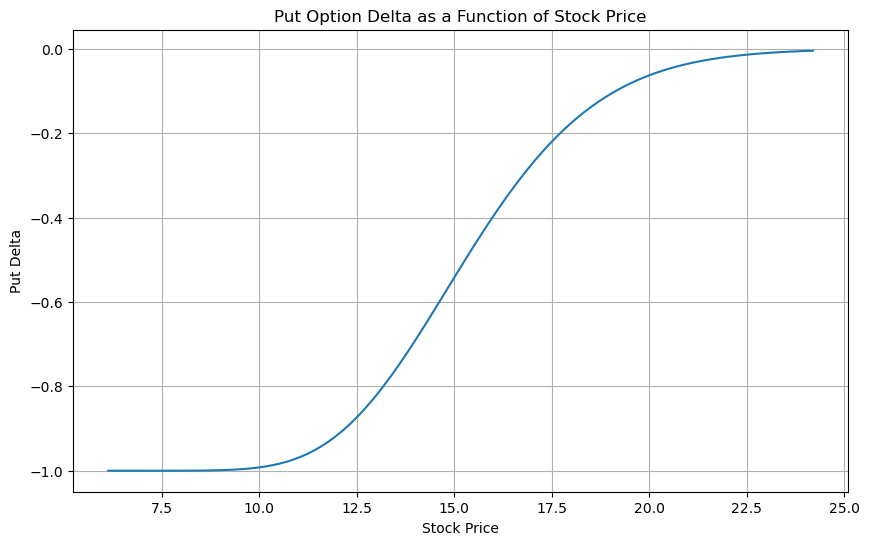

In [58]:
plt.figure(figsize=(10, 6))
# Calculate the put option delta for each stock price in stock_price
put_delta = [mibian.BS([stock_price, strike_price, risk_free_rate, time_to_expiration], volatility=implied_volatility).putDelta for stock_price in stock_price]

# Calculate the call option delta for each stock price in stock_price
call_delta = [mibian.BS([stock_price, strike_price, risk_free_rate, time_to_expiration], volatility=implied_volatility).callDelta for stock_price in stock_price]

# Plot the put option delta as a function of stock price
plt.plot(stock_price, put_delta)

# Set the labels and title for the plot
plt.xlabel('Stock Price')
plt.ylabel('Put Delta')
plt.title('Put Option Delta as a Function of Stock Price')

# Enable grid lines
plt.grid(True)

# Show the plot
plt.show()


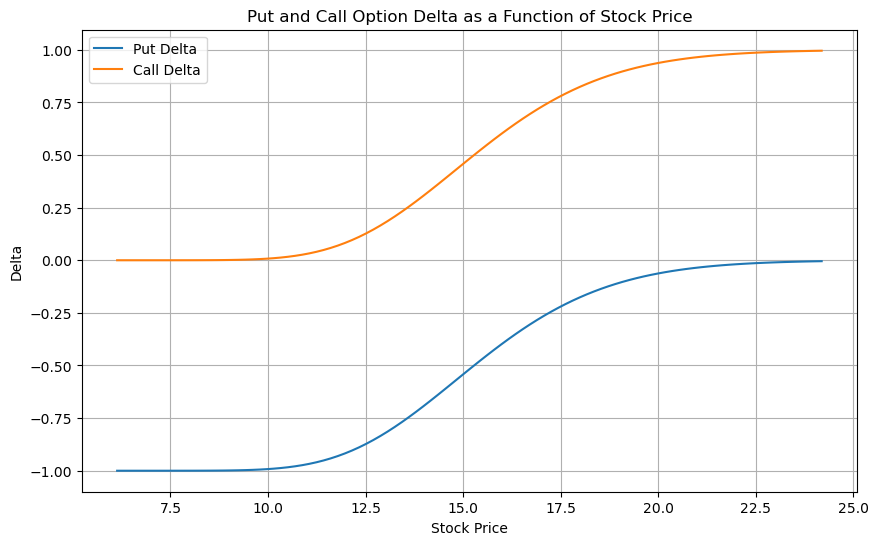

In [59]:
plt.figure(figsize=(10, 6))
# Plot the put option delta and call option delta as a function of stock price
plt.plot(stock_price, put_delta, label='Put Delta')
plt.plot(stock_price, call_delta, label='Call Delta')

# Set the labels and title for the plot
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Put and Call Option Delta as a Function of Stock Price')

# Display the legend
plt.legend()

# Enable grid lines
plt.grid(True)

# Show the plot
plt.show()

